# Scope of this workbook

Here, we want to actually model the whole thing for different datasets. 

In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Processed Dataset

In [2]:
full_df = pd.read_pickle('../data/finalized/full_df.pkl')

#full_df.describe()

In [3]:
# temp 

# additional drop of variables that are not available at the start of day 

full_df.drop([
    'trans_time',
    'ground_delay',
], axis = 1, inplace = True)


In [4]:
full_df.head()

,ac_registration_x,Ac Type Code,sched_trans_time,flt_event_number,leg,block_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,sched_groundtime_before,Crewchange_before,rows_to_drop_grounddelay
0,ECLBAX,321,0,1,New Jessica-East Carmen,-9.0,5,3,6,205,95.0,first flt of day,0
1,ECLBAX,321,60,2,East Carmen-South Nathaniel,-9.0,5,8,10,500,95.0,both,0
2,ECLBAX,321,75,3,South Nathaniel-East Carmen,-14.0,5,11,14,710,75.0,no change,0
3,ECLBAX,321,70,4,East Carmen-Joneshaven,-11.0,5,15,17,935,80.0,both,0
4,ECLBAX,321,50,5,Joneshaven-East Carmen,-10.0,5,17,19,1070,50.0,no change,1


## Encoding & Train/Test split

In [5]:
# Creating dummy variables for all categorical variables
# Note: Onehotencoder is the better solution, however for simplicity let's use pandas for the moment

# Get object columns
full_df_objectcolumns = full_df.select_dtypes(include = ['object', 'category'])
varlist = full_df_objectcolumns.columns.values.tolist()

# get dummies
full_df_encoded = pd.get_dummies(full_df, columns = varlist, drop_first = True)

#filter = ['ac']
#print(str([i for i in full_df_encoded.columns if 'Route' not in i ])+"\n")

full_df_encoded.shape

(8422, 329)

In [6]:
# We split the forecast in two different forecasts - one for ground delay and one for block delay

# dropping the ground delay filter row
full_df_encoded_blockdelay = full_df_encoded.drop(['rows_to_drop_grounddelay'], axis = 1)
X_train_blockdelay_encoded, X_test_blockdelay_encoded, y_train_blockdelay_encoded, y_test_blockdelay_encoded = train_test_split(
    full_df_encoded_blockdelay.drop(['block_delay'], axis = 1), full_df_encoded_blockdelay['block_delay'], test_size=0.33, random_state=42)

# Filtering out rows which are skewing ground delay prediction
#full_df_encoded_grounddelay = full_df_encoded[full_df_encoded['rows_to_drop_grounddelay'] == 0]

#X_train_grounddelay_encoded, X_test_grounddelay_encoded, y_train_grounddelay_encoded, y_test_grounddelay_encoded = train_test_split(
#    full_df_encoded_grounddelay.drop(['ground_delay'], axis = 1), full_df_encoded_grounddelay['ground_delay'], test_size=0.33, random_state=42)

'''#Hinnerk****************************************************************************************************

# dropping the ground delay filter row
full_df_encoded_blockdelay = full_df_encoded#.drop(['rows_to_drop_grounddelay'], axis = 1)
X_train_blockdelay_encoded, X_test_blockdelay_encoded, y_train_blockdelay_encoded, y_test_blockdelay_encoded = train_test_split(
    full_df_encoded_blockdelay.drop(['block_delay'], axis = 1), full_df_encoded_blockdelay['block_delay'], test_size=0.33, random_state=42)

# Filtering out rows which are skewing ground delay prediction
full_df_encoded_grounddelay = full_df_encoded#[full_df_encoded['rows_to_drop_grounddelay']<1]

X_train_grounddelay_encoded, X_test_grounddelay_encoded, y_train_grounddelay_encoded, y_test_grounddelay_encoded = train_test_split(
    full_df_encoded_grounddelay.drop(['ground_delay'], axis = 1), full_df_encoded_grounddelay['ground_delay'], test_size=0.33, random_state=42)
'''

"#Hinnerk****************************************************************************************************\n\n# dropping the ground delay filter row\nfull_df_encoded_blockdelay = full_df_encoded#.drop(['rows_to_drop_grounddelay'], axis = 1)\nX_train_blockdelay_encoded, X_test_blockdelay_encoded, y_train_blockdelay_encoded, y_test_blockdelay_encoded = train_test_split(\n    full_df_encoded_blockdelay.drop(['block_delay'], axis = 1), full_df_encoded_blockdelay['block_delay'], test_size=0.33, random_state=42)\n\n# Filtering out rows which are skewing ground delay prediction\nfull_df_encoded_grounddelay = full_df_encoded#[full_df_encoded['rows_to_drop_grounddelay']<1]\n\nX_train_grounddelay_encoded, X_test_grounddelay_encoded, y_train_grounddelay_encoded, y_test_grounddelay_encoded = train_test_split(\n    full_df_encoded_grounddelay.drop(['ground_delay'], axis = 1), full_df_encoded_grounddelay['ground_delay'], test_size=0.33, random_state=42)\n"

## Linear Regression


In [7]:
# Blocktime
lr_block = LinearRegression()

lr_block.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
lr_block.predict(X_test_blockdelay_encoded)

# Groundtime
#lr_ground = LinearRegression()

#lr_ground.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)
#lr_ground.predict(X_test_grounddelay_encoded)

array([ -4.9569337 ,  -5.19625687, -11.84673816, ...,  -9.68991526,
        -6.85583249,  -4.01473715])

In [8]:
# Blocktime
r2_blockdelay = lr_block.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, lr_block.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = lr_ground.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, lr_ground.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")

The r^2 for Block delay is -1896457.0249
The RMSE for Block delay is 9512.89 minutes.




## Setup of Modelling

In [9]:
# Imports 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [10]:
%%time
# Initialize estimators

#reg1 = LinearRegression()
reg2 = Ridge()
#reg3 = Lasso()
reg4 = GradientBoostingRegressor()
#reg5 = SVR()

# Initialize hyperparameters for each dictionary
#param1 = {}

param2 = {}
param2['regressor__alpha'] = [0,1,2,3]#[x for x in np.linspace(0,2,num = 4)]
param2['regressor'] = [reg2]

param4 = {}
param4['regressor__n_estimators'] = [52,55,56,57,58,59] #[10,50,100,150,250]#[10,50,100,150,200,250]
param4['regressor__max_depth'] = [12,13,14,15,16]#,18,20]#,18]#,22] #[2,3,6,8,10,12,18] #[2,3,4,6,8,10,12,15,18]
param4['regressor__max_leaf_nodes'] = [26,27,28,29,30]#[6,8,12,15,19,25]#,18] #[6,8,12,None] #[6,8,12,15,19,25,None]
param4['regressor'] = [reg4]


# Create Pipeline
pipeline = Pipeline([('regressor', reg2)])
params = [param2, param4]

# Train grid search model
gs_block = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_blockdelay_encoded,y_train_blockdelay_encoded)
#gs_ground = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_grounddelay_encoded,y_train_grounddelay_encoded)
#gs_block = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1).fit(X_train_blockdelay_encoded,y_train_blockdelay_encoded)
#gs_ground = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1).fit(X_train_grounddelay_encoded,y_train_grounddelay_encoded)
print(gs_block.best_estimator_, gs_block.best_params_)
#print(gs_ground.best_estimator_, gs_ground.best_params_)

#Evaluation
# Blocktime
r2_blockdelay = gs_block.best_estimator_.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, gs_block.best_estimator_.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = gs_ground.best_estimator_.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, gs_ground.best_estimator_.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")





Fitting 5 folds for each of 154 candidates, totalling 770 fits
Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(max_depth=13, max_leaf_nodes=29,
                                           n_estimators=56))]) {'regressor': GradientBoostingRegressor(max_depth=13, max_leaf_nodes=29, n_estimators=56), 'regressor__max_depth': 13, 'regressor__max_leaf_nodes': 29, 'regressor__n_estimators': 56}
The r^2 for Block delay is 0.2316
The RMSE for Block delay is 6.06 minutes.


CPU times: total: 4.58 s
Wall time: 3min 53s


In [32]:
# Evaluation per flight event number

full_df.head()

#Todo: delete rows with flt events >10
#for i in full_df['flt_event_number'].unique():
#    print(i)

RMSEs = []
for i in range(1,11):
    indices = X_test_blockdelay_encoded[X_test_blockdelay_encoded['flt_event_number']==i].index
    rmse_blockdelay_flt_event = np.sqrt(
        mean_squared_error(y_test_blockdelay_encoded.loc[indices], 
        gs_block.best_estimator_.predict(X_test_blockdelay_encoded.loc[indices]))
        )
    n = X_test_blockdelay_encoded.loc[indices].shape[0]
    print('RMSE for Landing Delay for flight ', i , ' is ', round(rmse_blockdelay_flt_event,2), ' minutes, using ', n, ' test observations')
    
    RMSEs.append(rmse_blockdelay_flt_event)


RMSE for Landing Delay for flight  1  is  6.0  minutes, using  527  test observations
RMSE for Landing Delay for flight  2  is  5.96  minutes, using  497  test observations
RMSE for Landing Delay for flight  3  is  5.93  minutes, using  486  test observations
RMSE for Landing Delay for flight  4  is  6.25  minutes, using  417  test observations
RMSE for Landing Delay for flight  5  is  5.98  minutes, using  342  test observations
RMSE for Landing Delay for flight  6  is  6.22  minutes, using  277  test observations
RMSE for Landing Delay for flight  7  is  6.59  minutes, using  139  test observations
RMSE for Landing Delay for flight  8  is  5.61  minutes, using  76  test observations
RMSE for Landing Delay for flight  9  is  5.25  minutes, using  11  test observations
RMSE for Landing Delay for flight  10  is  2.91  minutes, using  4  test observations


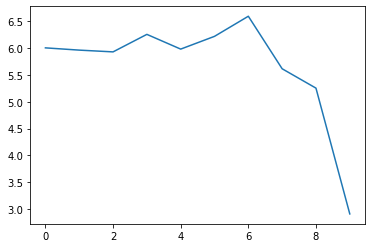

In [33]:
plt.plot(RMSEs)

# Evaluation of Best Model

In [11]:
# Attention: The message of this is limited as we have not scaled the variables 

feature_importances = gs_block.best_estimator_.steps[0][1].feature_importances_

d = {'Features': X_train_blockdelay_encoded.columns, 'Importance': feature_importances}
eval = pd.DataFrame(data = d).sort_values(by = 'Importance', ascending = False)
eval.head(50)

,Features,Importance
78,Ac Type Code_DH4,0.149283
5,minute_of_day_dep,0.101514
79,Ac Type Code_DHX,0.046577
247,leg_Lake Lawrencechester-Lake Richardberg,0.034249
2,day_of_week,0.032521
212,leg_East Latashaview-East Carmen,0.030831
4,hour_of_day_arr,0.029189
6,sched_groundtime_before,0.025679
80,Ac Type Code_E95,0.020803
0,sched_trans_time,0.020186


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
# Create dataframe to save model evaluation parameters
eval = pd.DataFrame(columns= ['Group', 'Model', 'Parameters', 'R^2 test', 'RMSE test', 'R^2 train', 'RMSE train'])

# Create ridge regression models with best alpha values
rid_block = Ridge(alpha=2, fit_intercept=True)
rid_ground = Ridge(alpha=2, fit_intercept=True)

# Fit models to training data
rid_block.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
rid_ground.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)

# Predict values for train and test data
rid_pred_block_train = rid_block.predict(X_train_blockdelay_encoded)
rid_pred_ground_train = rid_ground.predict(X_train_grounddelay_encoded)

rid_pred_block_test = rid_block.predict(X_test_blockdelay_encoded)
rid_pred_ground_test = rid_ground.predict(X_test_grounddelay_encoded)

# Save r^2 and RMSE for both models in dataframe for later comparison
eval = eval.append({
    'Group': 'Block',
    'Model': 'Ridge',
    'R^2 test': r2_score(y_test_blockdelay_encoded, rid_pred_block_test),
    'RMSE test': mean_squared_error(y_test_blockdelay_encoded, rid_pred_block_test, squared=False),
    'R^2 train': r2_score(y_train_blockdelay_encoded, rid_pred_block_train),
    'RMSE train': mean_squared_error(y_train_blockdelay_encoded, rid_pred_block_train, squared=False)
    }, ignore_index=True)
 
eval = eval.append({
    'Group': 'Ground',
    'Model': 'Ridge',
    'R^2 test': r2_score(y_test_grounddelay_encoded, rid_pred_ground_test),
    'RMSE test': mean_squared_error(y_test_grounddelay_encoded, rid_pred_ground_test, squared=False),
    'R^2 train': r2_score(y_train_grounddelay_encoded, rid_pred_ground_train),
    'RMSE train': mean_squared_error(y_train_grounddelay_encoded, rid_pred_ground_train, squared=False),
    }, ignore_index=True)

eval.round(decimals=3)

C:\Users\PC Paul\AppData\Local\Temp\ipykernel_18312\1589020009.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval = eval.append({
C:\Users\PC Paul\AppData\Local\Temp\ipykernel_18312\1589020009.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval = eval.append({


,Group,Model,Parameters,R^2 test,RMSE test,R^2 train,RMSE train
0,Block,Ridge,NaN,0.320295,5.734718,0.3692,5.378322
1,Ground,Ridge,NaN,0.672487,10.071233,0.718203,9.374951


## Gradient Boosted Tree

In [ ]:
# Gradientboosting as base classifier

# Blocktime
base_model_blockdelay = GradientBoostingRegressor()

base_model_blockdelay.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
base_model_blockdelay.predict(X_test_blockdelay_encoded)


# Groundtime

base_model_grounddelay = GradientBoostingRegressor()

base_model_grounddelay.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)
base_model_grounddelay.predict(X_test_grounddelay_encoded)


array([44.41952744, 13.83831236, 25.63892846, ..., 29.71946156,
       -0.62027353,  9.36199806])

In [ ]:
# Blocktime
r2_blockdelay = base_model_blockdelay.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, base_model_blockdelay.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
r2_grounddelay = base_model_grounddelay.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, base_model_grounddelay.predict(X_test_grounddelay_encoded)))
print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")

The r^2 for Block delay is 0.8795
The RMSE for Block delay is 6.55 minutes.


The r^2 for Ground delay is 0.902
The RMSE for Ground delay is 5.53 minutes.
